In [ ]:
# Project 5 – Expectation Maximization
# By: Sheikh Islam, Wilson Jimenez, & Talha Akhlaq

#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal
from scipy.stats import norm
import kagglehub
import pandas as pd
import numpy as np
import os

# 1-D Case

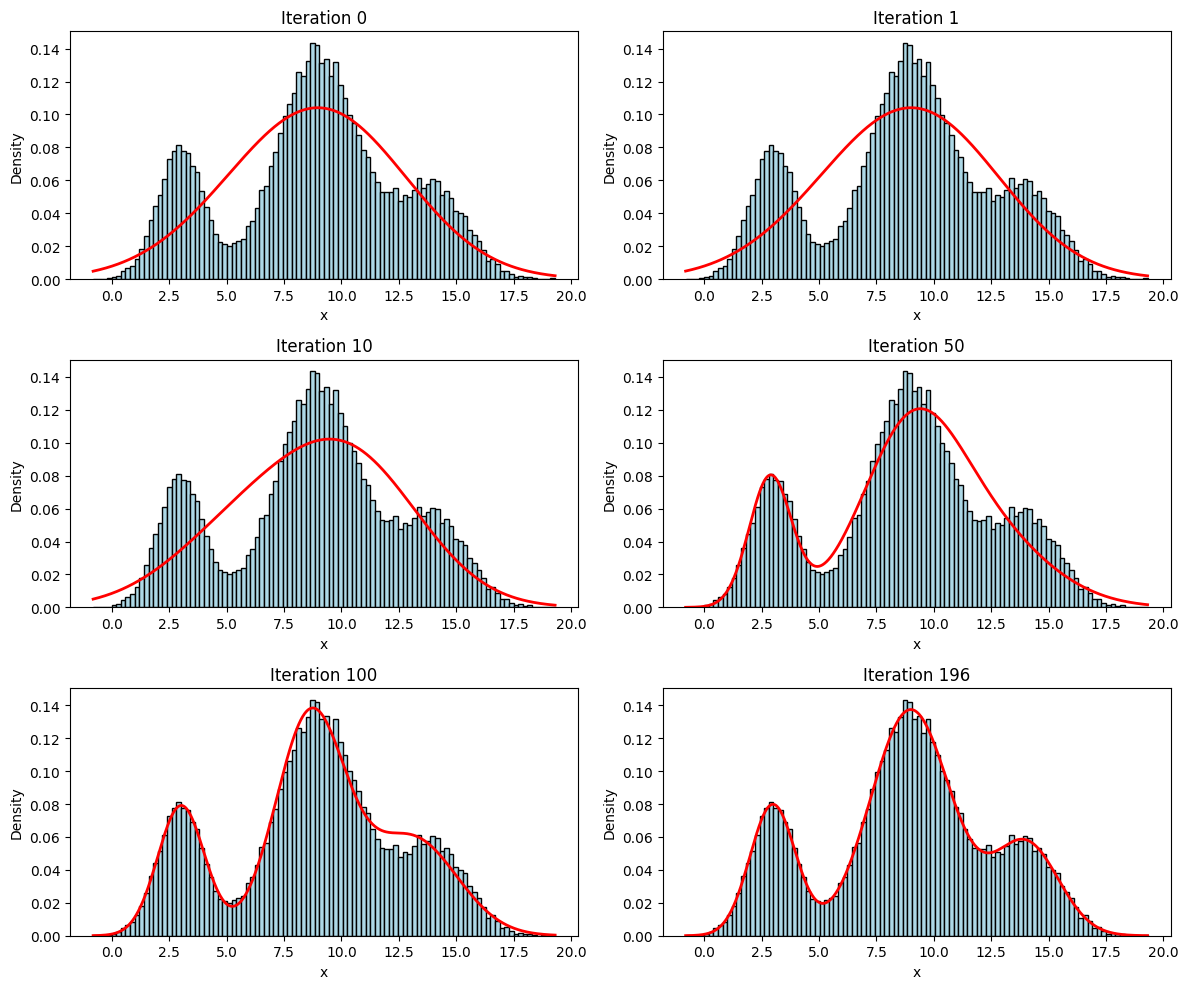

Converged in 196 iterations
Final parameter estimates:
  k=1:  mean=14.0028  var=2.0358  pi=0.2007
  k=2:  mean=2.9848  var=0.9851  pi=0.1977
  k=3:  mean=8.9898  var=3.0551  pi=0.6016


In [ ]:
#Choosing our means variance and weifhts for our own clusters
np.random.seed(35)
obs_means      = np.array([3.0,  9.0, 14.0])
obs_variances  = np.array([1.0,  3.0,  2.0])
obs_weights    = np.array([.2,  .6,  .2])

sample_size = 50000
pulls   = np.random.choice(3, size=sample_size, p=obs_weights)
samples = np.random.normal(obs_means[pulls], np.sqrt(obs_variances[pulls]))

K    = 3
mean = np.random.choice(samples, K) # random starts
var  = np.var(samples) * np.ones(K) # identical variance
pi   = np.full(K, 1.0 / K) # equal weights

#Setting a high iteration number but loop breaks once the log likelihood change is within our tol (tolerance)
max_iter = 1000
tol      = 1e-3
prev_ll  = 0 #previous log liklihood

x_axis = np.linspace(samples.min(), samples.max(), 1000)
benchmark_iters = [0, 1, 10, 50, 100, 196] #diff values to take a look at
densities = {} #storing densities to plot each of those snapshots

for it in range(max_iter):
    gamma = np.zeros((sample_size, K)) #setting up gamma to store the responsibilities
    for k in range(K):
        gamma[:, k] = pi[k] * norm.pdf(samples, mean[k], np.sqrt(var[k])) #numerator of equation 9.23
    gamma /= gamma.sum(axis=1, keepdims=True) #divide by the denominator of 9.23 to get gamma

    N_k = gamma.sum(axis=0) #equation 9.27 summing the responsibilities up
    mean = (gamma.T @ samples) / N_k #equation 9.24 where we get a new mean

    #equation 9.25 for the new variance parameter
    var = np.zeros(K)
    for k in range(K):
      diff_squared = (samples - mean[k])**2
      weighted_difference = gamma[:, k] * diff_squared
      var[k] = np.sum(weighted_difference) / N_k[k]

    pi   = N_k / sample_size #equation 9.26 for new weights

    #pulling pdf values to compute log liklihood in order to compare to previous log liklihood to look for convergence
    pdf_vals = np.zeros(sample_size)
    for k in range(K):
        pdf_vals += pi[k] * norm.pdf(samples, mean[k], np.sqrt(var[k]))
    log_likelihood = np.sum(np.log(pdf_vals))

    #pulling our pdfs from the benchmarks that we want
    if it in benchmark_iters:
      pdf_combined = np.zeros_like(x_axis)
      for k in range(K):
          pdf_combined += pi[k] * norm.pdf(x_axis, mean[k], np.sqrt(var[k]))
      densities[it] = pdf_combined

    #break loop if our criteria for convergence is met
    if np.abs(log_likelihood - prev_ll) < tol:
        break

    prev_ll = log_likelihood

x_axis = np.linspace(samples.min(), samples.max(), 1000)

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
axes = axes.ravel()

for index, it in enumerate(benchmark_iters):
    ax = axes[index]
    ax.hist(samples, bins=100, density=True, color='lightblue', edgecolor='black')
    ax.plot(x_axis, densities[it], 'r', linewidth=2)
    ax.set_title(f"Iteration {it}")
    ax.set_xlabel("x")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

print(f'Converged in {it} iterations')
print("Final parameter estimates:")
for k in range(K):
    print(f"  k={k+1}:  mean={mean[k]:.4f}  var={var[k]:.4f}  pi={pi[k]:.4f}")

# 2-D Case

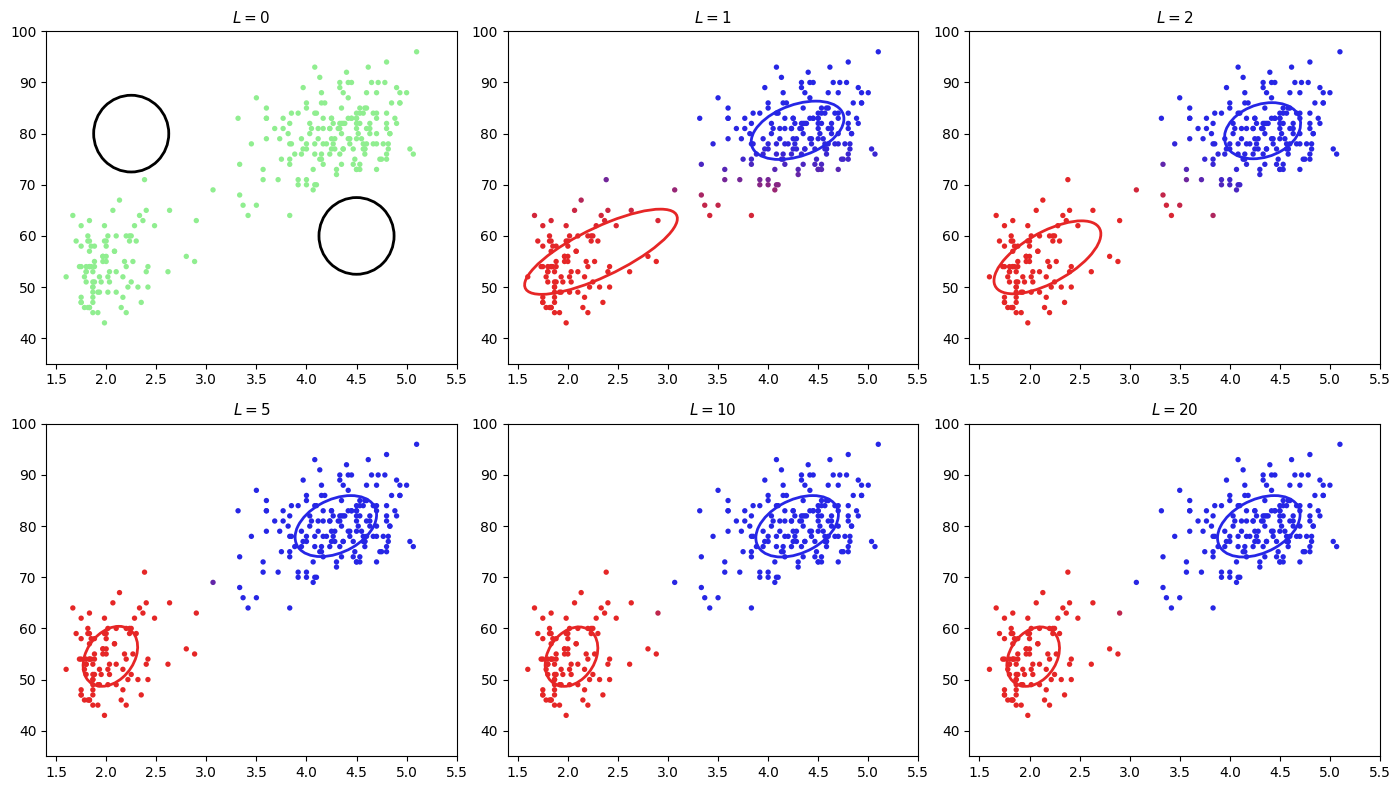

In [ ]:
# Download latest version
path = kagglehub.dataset_download("janithwanni/old-faithful")

df = pd.read_csv(os.path.join(path, "faithful.csv"))  # replace with actual filename if different
data = df.to_numpy()
x = data[:, 1] # eruption duration
y = data[:, 2] # waiting time

data = np.column_stack((x, y))
N, D = data.shape

K        = 2
pi       = [1/2, 1/2] #assume equal weights for now
mu = np.array([[2.25, 80],[4.5,  60]]) #choosing my own random centers to start from
overallσ = data.std(axis=0).mean()
Sigma_list = []
for _ in range(K):
    Sigma_list.append(np.eye(D) * overallσ**2)
Sigma = np.array(Sigma_list)

benchmark_iters = [0, 1, 2, 5, 10, 20] #where to create graphs for
benchmarks = {0: (None, mu.copy(), Sigma.copy())}  # we do not obtain a gamma value for 0 observations so we are filling that first one in

for it in range(1, 21):

    gamma_columns = []
    for k in range(K):
      col = pi[k] * multivariate_normal.pdf(data, mu[k], Sigma[k])
      gamma_columns.append(col)
    gamma = np.column_stack(gamma_columns) #gets us the numerator of 9.23
    gamma /= gamma.sum(axis=1, keepdims=True) #divide by the denominator of 9.23 to get gamma

#crafting out new mu, sigma, and pi based on the equations
    N_k  = gamma.sum(axis=0)
    mu  = (gamma.T @ data) / N_k[:, None]
    Sigma = np.array([((gamma[:,k,None,None] * (data - mu[k])[:,:,None] @ (data - mu[k])[:,None,:]).sum(axis=0) / N_k[k]) for k in range(K)])
    pi = N_k / N

#extracting data if its one of the iterations we want to plot
    if it in benchmark_iters:
        benchmarks[it] = (gamma.copy(), mu.copy(), Sigma.copy())

#setting up our subplots
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
axs = axs.ravel()
colors = np.array([[0.15, 0.15, 0.9], [0.9, 0.15, 0.15]])

#looping through our benchmark iterations to plot what we want. for 0 since thats the initilization just plotting our chosen means and then for the rest plotting an elipse with our extracted data
for ax, key in zip(axs, benchmark_iters):
    gamma_k, mu_k, Sig_k = benchmarks[key]

#plotting the inital conditions
    if key == 0:
      ax.scatter(data[:,0], data[:,1], c='lightgreen', s=15, edgecolor='none')
      fixed_centers = [(2.25, 80), (4.5, 60)]
      for center in fixed_centers:
        e = Ellipse(xy=center, width=.75, height=15, angle=0, ec='k', fc='none', lw=2)
        ax.add_patch(e)

#plotting the updated values for benchmark iterations and
    else:
        blend = gamma_k @ colors
        ax.scatter(data[:,0], data[:,1], c=blend, s=15, edgecolor='none')
        for k, col in enumerate(colors):
          #sorting and storing the eigenvectors and eigenvalues in order to use for plotting elipse with angle
          vals, vecs = np.linalg.eigh(Sig_k[k])
          i = vals.argsort()[::-1]
          vals, vecs = vals[i], vecs[:, i]
          ang = np.degrees(np.arctan2(*vecs[:,0][::-1]))

          w, h = 2*np.sqrt(vals) #circle with one std width
          e = Ellipse(xy=mu_k[k], width=w, height=h, angle=ang, ec=col, fc='none', lw=2)
          ax.add_patch(e)

    ax.set_title(fr"$L={key}$", fontsize=11)
    ax.set_xlim(1.4, 5.5)
    ax.set_ylim(35, 100)

plt.tight_layout()
plt.show()